# Context Encoder Comparison

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
import pandas as pd
import os
import ast
import warnings
from tqdm import tqdm
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from bachelors_thesis.modeling.siglabv2.siglabv2 import SigLabV2, BlindSigLabV2
from bachelors_thesis.modeling.siglabv2.siglab_nocontext import SigLabNoContext
from bachelors_thesis.modeling.siglabv2.siglab_deepsets import SigLabDeepsets
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.run import lead_sets
from bachelors_thesis.utils import count_parameters, confusion_matrix, apply_preprocessors, PRECORDIAL_LEAD_NAMES, hungarian_predictions
from bachelors_thesis.evaluation import lead_level_accuracy, set_level_accuracy
from bachelors_thesis.data.load_ptbdata_new import PRECORDIAL_LEADS, LIMB_LEADS, AUGMENTED_LEADS, ALL_LEADS

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams.update({ "font.family": "serif", "font.serif": ["Times New Roman"], "mathtext.fontset": "cm"}) # for math symbols })

2025-05-27 20:21:36.533 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


# No Context

In [3]:
run_ids = [
    "tjfs7cig",
    "yh0by5uj",
    "3almvn1d"
]
versions = [
    "v10",
    "v30",
    "v17"
]
labels = [
    "None",
    "Set Attention",
    "DeepSets"
]

models = []

In [4]:
project_path = "nateml-maastricht-university/bachelors-thesis"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb
api = wandb.Api()

for run_id, version in zip(run_ids, versions):
    run = api.run(f"{project_path}/{run_id}")
    config = dict(run.config)

    # Get the run name
    run_name = run.name

    artifact = api.artifact(f"{project_path}/{run_name}:{version}")
    artifact_path = artifact.download()

    # Convert config to omegaconf
    cfg = OmegaConf.create(config)

    # Load the model
    checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

    # Cast the model to the correct type
    if OmegaConf.select(cfg, "model.sab") is not None:
        model = SigLabV2(cfg.model).to(device)
    elif OmegaConf.select(cfg, "model.deepsets") is not None:
        model = SigLabDeepsets(cfg.model).to(device)
    else:
        model = SigLabNoContext(cfg.model).to(device)
    model.load_state_dict(checkpoint)
    model.eval()  # Put into evaluation mode

    models.append(model)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [5]:
dataset_path = Path("../../" + cfg.dataset.path)
if OmegaConf.select(cfg, "dataset.only_precordial"):
    dataset_path = dataset_path / "precordial"
else:
    dataset_path = dataset_path / "all"
dataset_path = dataset_path.resolve()

test_data = np.load(dataset_path / "test.npy")

# Apply preprocessors
test_data = apply_preprocessors(test_data,
                                 cfg.dataset.sampling_rate,
                                 cfg.preprocessor_group.preprocessors)
 
# Convert to torch tensor
test_data = torch.from_numpy(test_data).float().to(device)
test_data = test_data.permute(0, 2, 1)

# Create the dataset and dataloader
lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
dataset = SigLocDataset(test_data, filter_leads=lead_filter)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# I need to reorder val_data to match the order of the labels in the dataset
if OmegaConf.select(cfg, "dataset.only_precordial") or OmegaConf.select(cfg, "dataset.only_precordial") is None:
    test_data = test_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
else:
    test_data = test_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]

# Load metadata
meta_val = pd.read_csv(dataset_path / "meta_val.csv")
meta_test = pd.read_csv(dataset_path / "meta_test.csv")
meta = meta_test.copy()
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))

# Treat diagnostic superclass as lists
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: ast.literal_eval(x))
# Now convert to a set
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: set(x))

c = cfg.model.num_classes  # Should be the same for all models
logits = {name: np.zeros((len(dataset), c, c)) for name in labels}
targets = {name: np.zeros((len(dataset), c)) for name in labels}
predictions = {name: np.zeros((len(dataset), c)) for name in labels}

for model, name in zip(models, labels):
    for idx, (signals, lead_labels) in enumerate(tqdm(dataloader)):
        signals = signals.to(device)
        lead_labels = lead_labels.to(device)

        # Make predictions
        with torch.no_grad():
            these_logits = model(signals)
            logits[name][(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
            targets[name][(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

    predictions[name] = logits[name].argmax(axis=1)

100%|██████████| 69/69 [00:01<00:00, 35.88it/s]


In [6]:
data = {name: [] for name in labels}
for name in labels:
    lead_acc = lead_level_accuracy(predictions=predictions[name], targets=targets[name])
    set_acc = set_level_accuracy(predictions=predictions[name], targets=targets[name])
    data[name].append(lead_acc)
    data[name].append(set_acc)

    print(f"Model: {name}") 
    print(f"Lead level accuracy: {lead_acc:.4f}")
    print(f"Set level accuracy: {set_acc:.4f}")
    print()

Model: None
Lead level accuracy: 0.6769
Set level accuracy: 0.0933

Model: Set Attention
Lead level accuracy: 0.9816
Set level accuracy: 0.9486

Model: DeepSets
Lead level accuracy: 0.9583
Set level accuracy: 0.8676



In [7]:
# Hungarian algorithm
hungarian_data = {name: [] for name in labels}
for name in labels:
    hungarian_preds = hungarian_predictions(logits[name])

    hung_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets[name])
    hung_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets[name])
    hungarian_data[name].append(hung_lead_acc)
    hungarian_data[name].append(hung_set_acc)

    print(f"Hungarian model: {name}")
    print(f"Hungarian lead level accuracy: {hung_lead_acc:.4f}")
    print(f"Hungarian set level accuracy: {hung_set_acc:.4f}")
    print()

Hungarian model: None
Hungarian lead level accuracy: 0.9312
Hungarian set level accuracy: 0.8508

Hungarian model: Set Attention
Hungarian lead level accuracy: 0.9816
Hungarian set level accuracy: 0.9513

Hungarian model: DeepSets
Hungarian lead level accuracy: 0.9663
Hungarian set level accuracy: 0.9186



# Visuals

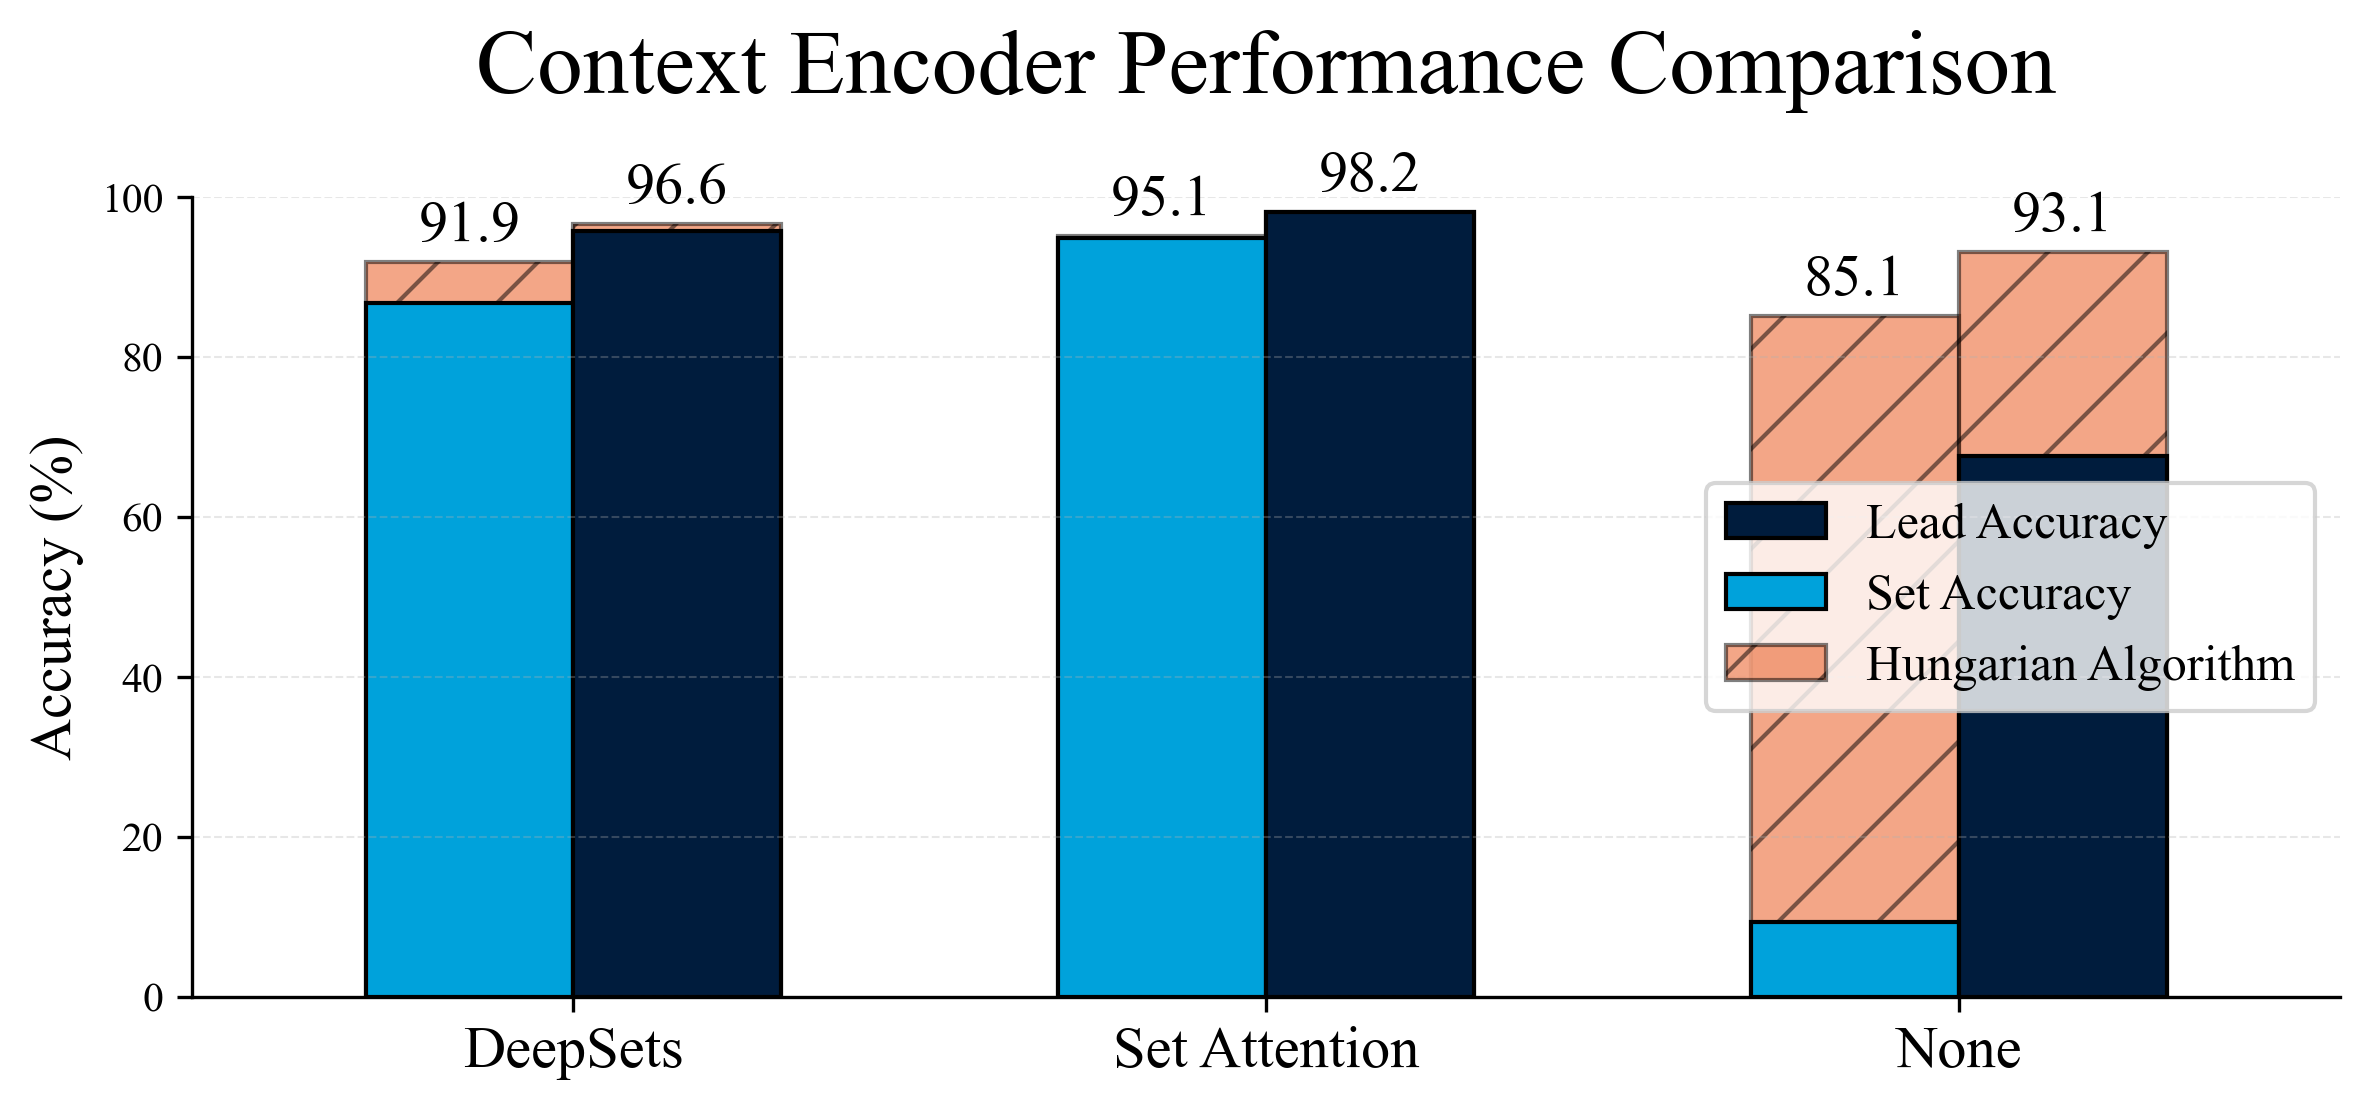

'figures/context_encoder_comparison_narrow_2'

In [12]:
# Maastricht University brand colours
light_blue = "#00A2DB"
dark_blue  = "#001C3D"
orange_red = "#E84E10"
red = "#AE0B12"
orange = "#F39425"

# I didn't make this data up I swear
df = pd.DataFrame(data, index=['Lead Accuracy', 'Set Accuracy']).T
hungarian_df = pd.DataFrame(hungarian_data, index=['Lead Accuracy', 'Set Accuracy']).T

# Reorder the index
order = ['DeepSets', 'Set Attention', 'None']
df = df.reindex(order)
hungarian_df = hungarian_df.reindex(order)

# Reorder the columns
df = df[['Set Accuracy', 'Lead Accuracy']]
hungarian_df = hungarian_df[['Set Accuracy', 'Lead Accuracy']]

# Multiply by 100 to get percentage
df = df * 100
hungarian_df = hungarian_df * 100

# Figure
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
hungarian_df.plot(kind='bar', ax=ax, color=orange_red, edgecolor='black', width=0.6, alpha=0.5, hatch='/', fill=True)
df.plot(kind='bar', ax=ax, color=[light_blue, dark_blue], edgecolor='black', width=0.6, alpha=1)

# Labels & limits
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='regular')
#ax.set_xlabel('Context Encoder', fontsize=10, fontweight='semibold')
ax.set_ylim(0, 100)
ax.set_xticklabels(df.index, fontsize=14, fontweight='regular', rotation=0)

# Make y tick labels fontweight semibold
for label in ax.get_yticklabels():
    label.set_fontweight('regular')

# Add extra padding below title (in points)
ax.set_title('Context Encoder Performance Comparison', fontsize=22, pad=25, fontweight='regular')

# Tick & legend
#plt.xticks(rotation=0, fontsize=9)
#ax.legend(['Set Accuracy', 'Lead Accuracy'], fontsize=10)
#ax.legend([reg, hung], ['Hungarian Accuracy', 'Set Accuracy', 'Lead Accuracy'])
# Only show the legend for the regular bars
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]
labels[0] = 'Hungarian Algorithm'
# Reverse order
handles = handles[::-1]
labels = labels[::-1]
# Change background color of legend
ax.legend(handles, labels, fontsize=12, frameon=True, facecolor='white', loc='center right')
# Change the font weight of the legend
for text in ax.legend_.get_texts():
    text.set_fontweight('regular')

# Annotate bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 2),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=14, color='black',
                fontweight='regular',)

    if i > 4:
        break

# Aesthetics
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.5)

# Adjust layout leaving room for title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save hi‑res PDF
file_path = 'figures/context_encoder_comparison_narrow_2'
plt.savefig(file_path + '.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(file_path + '.png', format='png', bbox_inches='tight', dpi=400)

plt.show()

file_path